In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_file = 'images/field-pic-1.png'

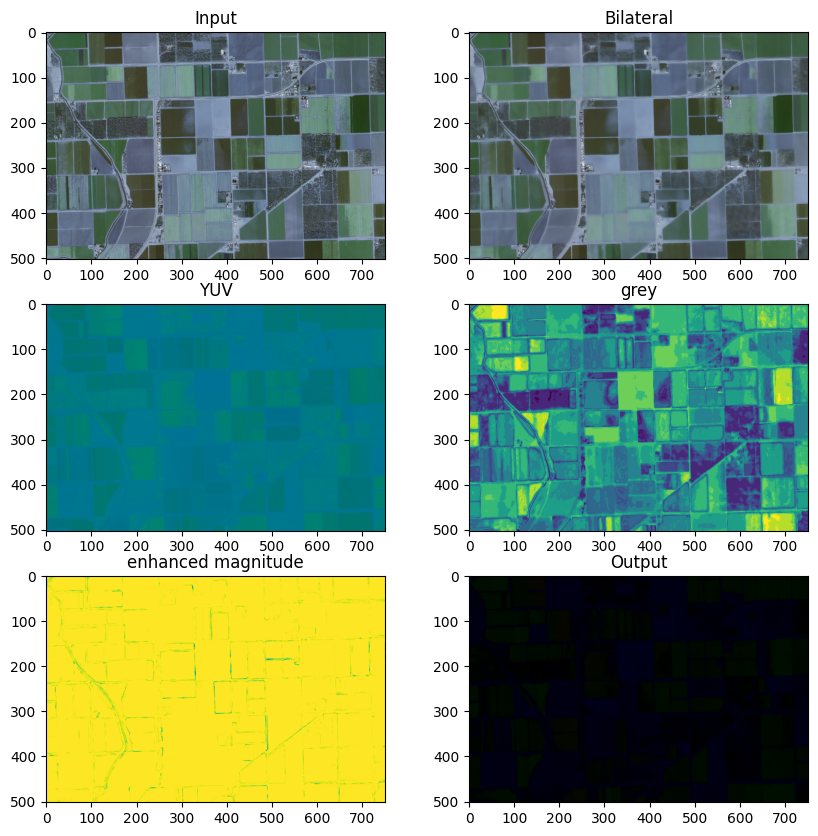

In [2]:
import cv2
import numpy as np

# Load your image
image = cv2.imread(image_file)

# Image Pre-Processing
# Apply bilateral filtering for noise reduction and edge preservation
bilateral_filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

# Convert the image to YUV color space
yuv_image = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2YUV)

# Apply sigmoid transformation to enhance contrast
def sigmoid(x, alpha, x0):
    return 1 / (1 + np.exp(-alpha * (x - x0)))

alpha_sigmoid = 1.0  # You can adjust this value
x0_sigmoid = 128.0   # You can adjust this value
yuv_image[:, :, 0] = sigmoid(yuv_image[:, :, 0], alpha_sigmoid, x0_sigmoid)

# Convert the enhanced image back to RGB
enhanced_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

# Edge Detection
# Convert the enhanced image to grayscale
gray_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)

# Apply Sobel operator for gradient calculation
gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate gradient magnitude and direction
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_direction = np.arctan2(gradient_y, gradient_x)

# Apply Meijering filter to enhance edge features
def meijering_filter(image):
    return (image ** 2) * (3 - 2 * image)

enhanced_gradient_magnitude = meijering_filter(gradient_magnitude)

# Seed Point Selection (You will need to implement this based on your requirements)

# Graph-Based Growing Contours (You will need to implement this based on your requirements)

# Polygon Creation and Post-Processing (You will need to implement this based on your requirements)

# Display or save the final result
plt.figure(figsize=[10, 10])
ax=plt.subplot(3,2,1)
ax.set_title("Input")
plt.imshow(image)

ax=plt.subplot(3,2,2)
ax.set_title("Bilateral")
plt.imshow(bilateral_filtered_image)

ax=plt.subplot(3,2,3)
ax.set_title("YUV")
plt.imshow(yuv_image)

ax=plt.subplot(3,2,4)
ax.set_title("grey")
plt.imshow(gray_image)

ax=plt.subplot(3,2,5)
ax.set_title("enhanced magnitude")
plt.imshow(enhanced_gradient_magnitude)

ax=plt.subplot(3,2,6)
ax.set_title("Output")
plt.imshow(enhanced_image)
plt.show()

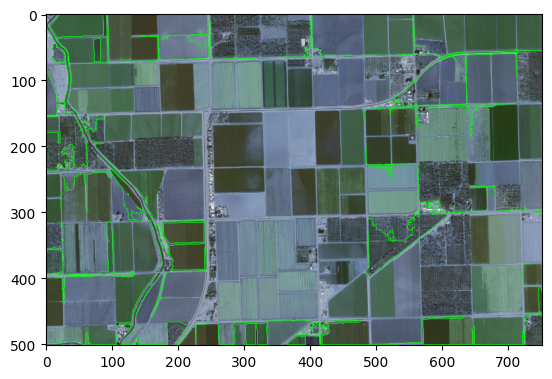

In [3]:
import cv2
import numpy as np

def graph_grwoing(image):
    # Define the size of the image tiles (50x50 pixels)
    tile_size = (50, 50)

    # Create a mask for the segmented region
    mask = np.zeros_like(image)

    # Define the threshold for region growing
    threshold = 30

    # Define the step size for moving the seed points
    step_x = tile_size[0]
    step_y = tile_size[1]

    # Iterate over the image in tiles
    for y in range(0, image.shape[0], step_y):
        for x in range(0, image.shape[1], step_x):
            # Seed point selection for each tile (center of the tile)
            seed_x = x + tile_size[0] // 2
            seed_y = y + tile_size[1] // 2

            # Initialize the stack for graph-based growing
            stack = [(seed_x, seed_y)]

            while stack:
                x, y = stack.pop()

                # Check if the pixel is within the image boundaries
                if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                    # Check if the pixel is not already part of the segmented region
                    if mask[y, x].all() == 0:
                        # Check the intensity difference between the seed pixel and the current pixel
                        diff = np.abs(image[y, x].astype(int) - image[seed_y, seed_x].astype(int))

                        # If the difference is below the threshold, add the pixel to the region
                        if np.all(diff < threshold):
                            mask[y, x] = [255, 255, 255]  # Mark the pixel as part of the region
                            stack.append((x + 1, y))
                            stack.append((x - 1, y))
                            stack.append((x, y + 1))
                            stack.append((x, y - 1))

    # Find contours in the mask
    contours, _ = cv2.findContours(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the original image
    output = image.copy()
    cv2.drawContours(output, contours, -1, (0, 255, 0), 1)  # Green contours
    return output

image = cv2.imread(image_file)
output = graph_grwoing(image)
plt.imshow(output)

# Holistically Nested Edge Detection

## Load the Model:

In [4]:
# !git clone git@github.com:ashukid/hed-edge-detector.git

In [5]:
# import os
# os.chdir('hed-edge-detector')

In [6]:
# !python edge_detector.py --input ..\\images\\field-pic-1.png --prototxt deploy.prototxt --caffemodel hed_pretrained_bsds.caffemodel  --width 700 --height 500
# image = cv2.imread("out.jpg")
# plt.imshow(image)

In [7]:
import numpy as np
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = int((inputShape[2] - targetShape[2]) / 2)
        self.xstart = int((inputShape[3] - targetShape[3]) / 2)
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:, :, self.ystart:self.yend, self.xstart:self.xend]]
# Load the model.
net = cv2.dnn.readNetFromCaffe("hed-edge-detector\\deploy.prototxt", "hed-edge-detector\\hed_pretrained_bsds.caffemodel")
cv2.dnn_registerLayer('Crop', CropLayer)

def hed(image):
    width, height, c = image.shape

    # image = cv2.imread(args.input)
    # image = cv2.resize(image, (args.width, args.height))

    inp = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(width, height),
                               mean=(104.00698793, 116.66876762, 122.67891434),
                               swapRB=False, crop=False)
    net.setInput(inp)
    # edges = cv2.Canny(image,image.shape[1],image.shape[0])
    out = net.forward()

    out = out[0, 0]
    out = cv2.resize(out, (image.shape[1], image.shape[0]))

    # print(out.shape)
    out = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)
    out = 255 * out
    out = out.astype(np.uint8)
    
    return out

error: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/dnn/src/caffe/caffe_io.cpp:1126: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "hed-edge-detector\deploy.prototxt" in function 'ReadProtoFromTextFile'


In [ ]:
def dehaze(image, omega=0.95, tmin=0.1):
    # Calculate the dark channel of the image
    min_channel = np.min(image, axis=2)

    # Estimate the atmospheric light using the top 'omega' percentage of brightest pixels
    num_pixels = min_channel.size
    num_brightest = int(num_pixels * omega)
    flat_dark_channel = min_channel.flatten()
    indices = np.argpartition(flat_dark_channel, -num_brightest)[-num_brightest:]
    atmospheric_light = np.max(image.reshape(-1, 3)[indices], axis=0)

    # Calculate the transmission map
    transmission = 1 - omega * min_channel / np.max(atmospheric_light)

    # Clip transmission values to ensure they are not too small
    transmission = np.maximum(transmission, tmin)

    # Estimate the scene radiance
    scene_radiance = np.zeros_like(image, dtype=np.float32)
    for i in range(3):
        scene_radiance[:, :, i] = (image[:, :, i] - atmospheric_light[i]) / transmission + atmospheric_light[i]

    scene_radiance = np.clip(scene_radiance, 0, 255)

    return scene_radiance

def sharpen_image(image, sigma=1.0, alpha=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, alpha + 1, blurred, -alpha, 0)
    return sharpened

def fft_edge(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Perform FFT
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Define a high-pass filter mask
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow - 30:crow + 30, ccol - 30:ccol + 30] = 1

    # Apply the high-pass filter
    fshift_filtered = fshift * mask

    # Perform Inverse FFT
    f_ishift = np.fft.ifftshift(fshift_filtered)
    image_back = np.fft.ifft2(f_ishift)
    image_back = np.abs(image_back)

    # Normalize the result to 8-bit for display
    edge_detected = cv2.normalize(image_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply thresholding to get binary edges
    _, edges = cv2.threshold(edge_detected, 50, 255, cv2.THRESH_BINARY)
    return edges

In [ ]:
inpimg = cv2.imread(image_file)
image = hed(inpimg)


kernel = np.ones((5, 5), np.uint8)
closing_result = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

dhz = dehaze(image)
srp = sharpen_image(sharpen_image(sharpen_image(image)))
ggs = graph_grwoing(srp)
fft = fft_edge(image)


In [ ]:
# Display or save the final result
plt.figure(figsize=[10, 10])
ax=plt.subplot(3,2,1)
ax.set_title("fft")
plt.imshow(fft)

ax=plt.subplot(3,2,2)
ax.set_title("image")
plt.imshow(image)

ax=plt.subplot(3,2,3)
ax.set_title("closing_result")
plt.imshow(closing_result)

ax=plt.subplot(3,2,4)
ax.set_title("ggs")
plt.imshow(ggs)

ax=plt.subplot(3,2,5)
ax.set_title("srp")
plt.imshow(srp)

ax=plt.subplot(3,2,6)
ax.set_title("inpimg")
plt.imshow(inpimg)
plt.show()

In [ ]:
srp = image.copy()
times = 3
for i in range(times):
    srp = sharpen_image(srp)

    # Define a kernel (structuring element)
kernel = np.ones((2, 2), np.uint8)  # You can customize the size and shape of the kernel

# Perform erosion
srp = cv2.erode(srp, kernel, iterations=1)

# # Apply Gaussian blur to reduce noise (optional but recommended)
# blurred = cv2.GaussianBlur(srp, (5, 5), 0)

# # Perform Canny edge detection
# edges = cv2.Canny(blurred, threshold1=30, threshold2=100)

plt.figure(figsize=[10,5])
plt.imshow(srp)

In [ ]:
import numpy as np
import cv2

# Step 3.2: Image Pre-Processing
def image_preprocessing(image):
    # Implement masking of non-agricultural areas
    # Implement bilateral filtering for noise reduction and smoothing
    # Transform the image to the YUV color space
    # Apply sigmoid transform to increase contrast
    return preprocessed_image

# Step 3.3: Edge Detection and Enhancement
def edge_detection_and_enhancement(image):
    # Convolve with Sobel operator for gradient calculation
    # Calculate gradient magnitude and direction
    # Apply the Meijering filter to enhance field boundaries
    return enhanced_image

# Step 3.4: Graph-Based Growing Contours
def graph_based_growing_contours(enhanced_image):
    # Implement seed point selection
    # Create a local graph around each seed point
    # Define movement and termination criteria
    # Extract contours using the local graph
    return extracted_contours

# Step 3.5: Polygon Creation and Post-Processing
def create_and_post_process_polygons(extracted_contours):
    # Create a binary contour image from extracted contours
    # Apply flood fill algorithm to segment fields
    # Extract nodes within a certain distance from boundaries
    # Create a local graph for each field segment
    # Find the longest cycle in the local graph to form polygons
    return field_polygons

# Step 3.6: Selecting Optimal Parameters (Optional)
def select_optimal_parameters():
    # You can implement a parameter optimization algorithm here
    return optimal_parameters

# Load your remote sensing image
input_image = cv2.imread('your_remote_sensing_image.tif')

# Main Workflow
preprocessed_image = image_preprocessing(input_image)
enhanced_image = edge_detection_and_enhancement(preprocessed_image)
extracted_contours = graph_based_growing_contours(enhanced_image)
field_polygons = create_and_post_process_polygons(extracted_contours)
optimal_parameters = select_optimal_parameters()

# Print or save your field polygons and optimal parameters
print("Field Polygons:", field_polygons)
print("Optimal Parameters:", optimal_parameters)


# SAM

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/2x/kb1y9tvx01j9226b9fd1y13r0000gn/T/pip-req-build-9hw9oafj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/2x/kb1y9tvx01j9226b9fd1y13r0000gn/T/pip-req-build-9hw9oafj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=a066fe828f908a98615553964c553ff764da7a5c4393926ed3a8cfc4ea14f858
  Stored in directory: /private/var/folders/2x/kb1y9tvx01j9226b9fd1y13r0000gn/T/pip-ephem-wheel-cache-ikjpxcql/wheels/b0/7e/40/20f0b1e23280cc4a66dc8009c29f42cb4afc1b205bc5814786
Successfully built segment-anything


In [ ]:
!pip list | grep seg

segment-anything          1.0


In [8]:
def show_boundary(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.ones(3), [0.35]])
        
        img[m] = color_mask
    ax.imshow(img)

In [20]:
image_file = "images/field-pic-1.png"

In [21]:
import cv2
import cv2
import numpy as np

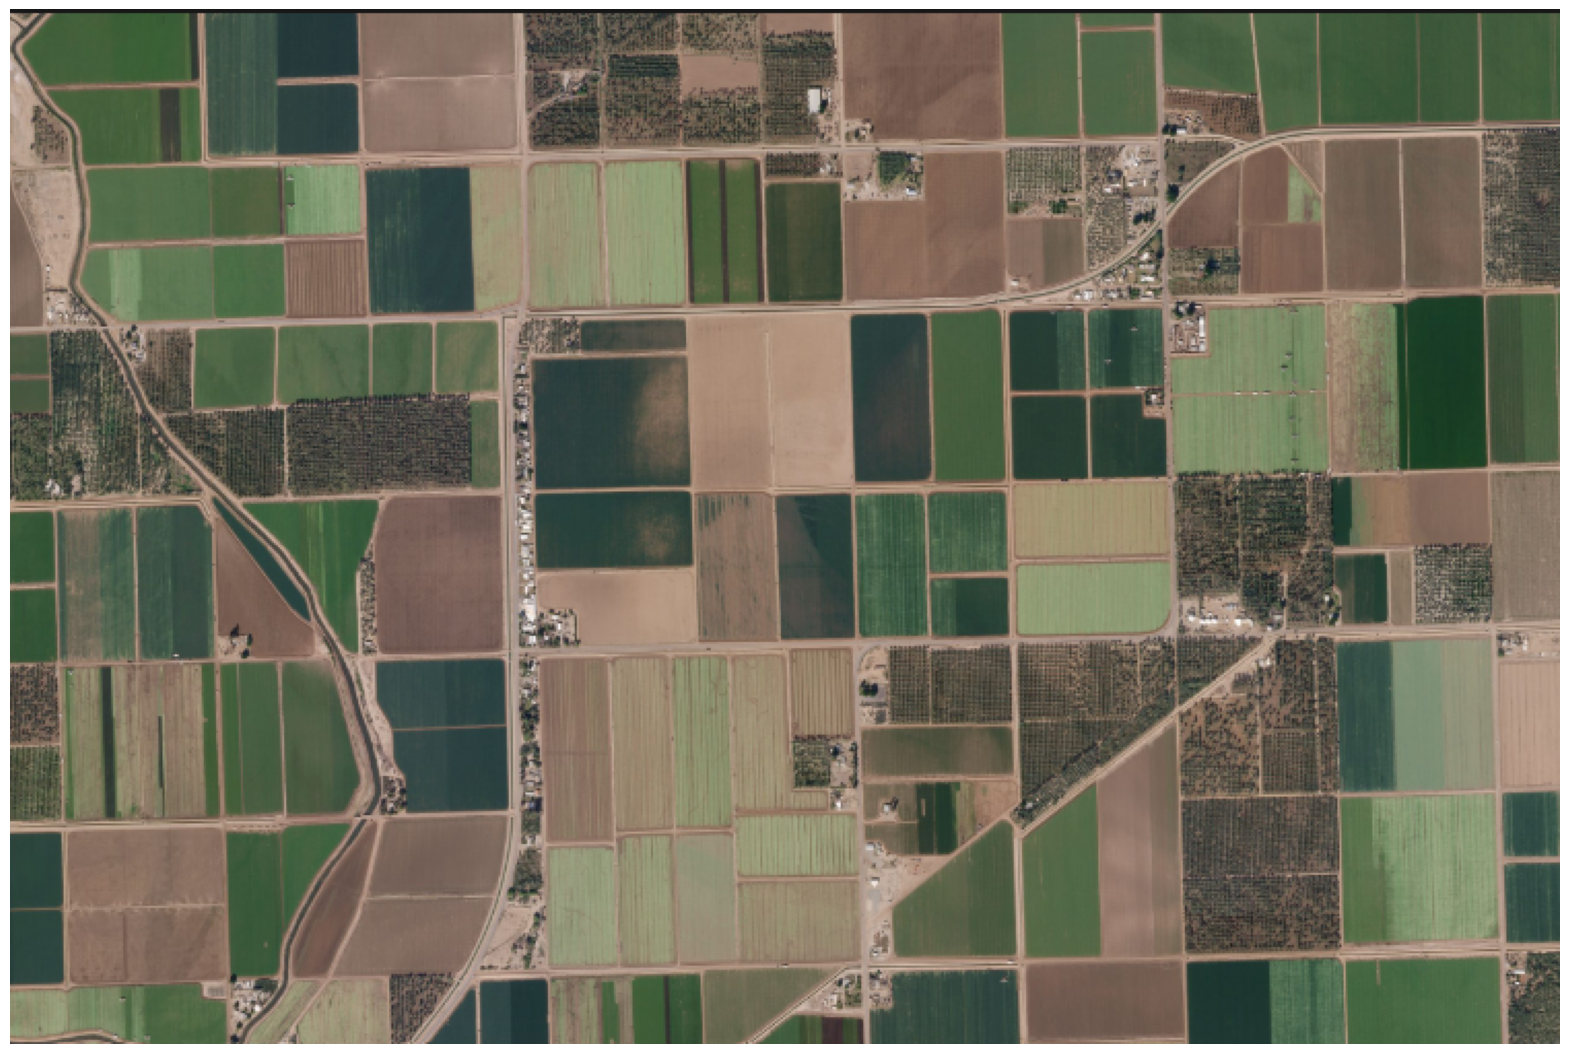

In [22]:
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [23]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["default"](checkpoint="/Users/soumensardar/Downloads/sam_vit_h_4b8939.pth")
device = "cpu"
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [18]:
scale_percent_1 = 10
width_1 = int(image.shape[1] * scale_percent_1 / 100)
height_1 = int(image.shape[0] * scale_percent_1 / 100)
dim_1 = (width_1, height_1)
# scaling the original image to defined dimensions
image2 = cv2.resize(image, dim_1, interpolation = cv2.INTER_AREA)

In [19]:
# masks = mask_generator.generate(image2)

In [17]:
# masks = mask_generator.generate(image2)

In [12]:
masks = mask_generator.generate(image)

In [13]:
# i = 1
# plt.imshow(masks[i]['segmentation'])

In [14]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    print(img.shape)
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [.3]])
        # print(color_mask)
        img[m] = color_mask
    ax.imshow(img)

uint8


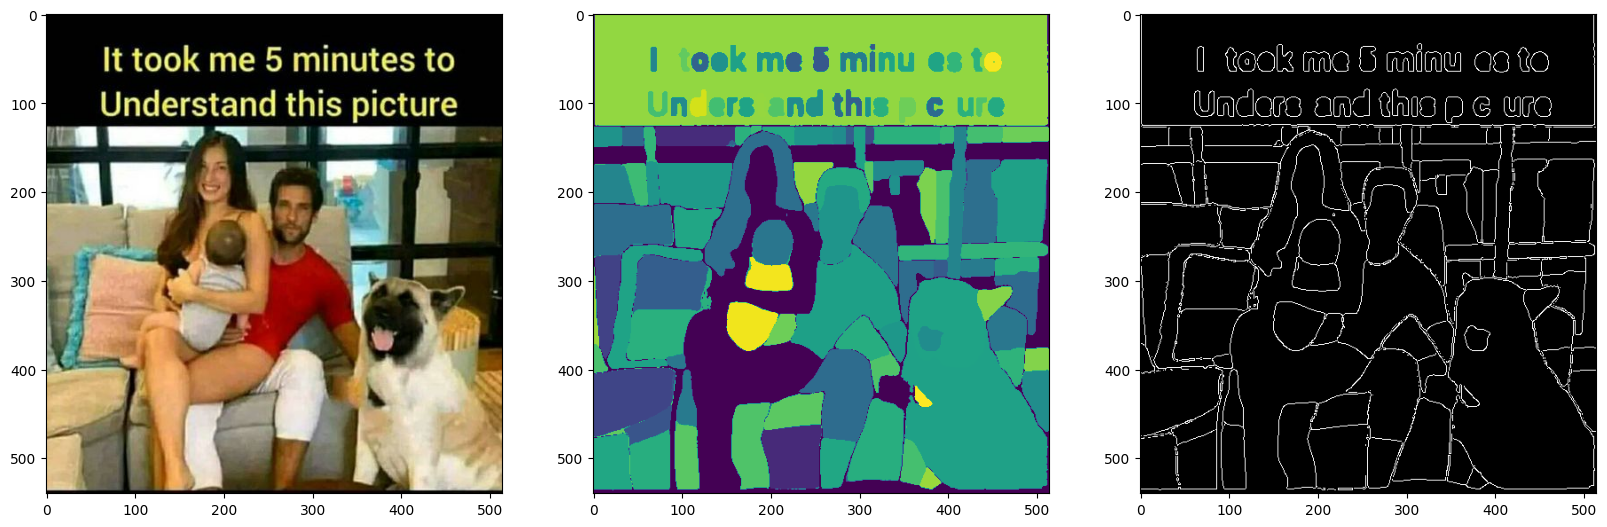

In [15]:

sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 3))
img[:, :, :] = 0
for ann in sorted_anns:
    m = ann['segmentation']
    color_mask = np.concatenate([np.random.random(3)])
    # print(color_mask)
    img[m] = color_mask

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(image)

img2 = (np.mean(img, axis=2)*255).astype('uint8')
plt.subplot(132)
plt.imshow(img2)
print(img2.dtype)
edges = cv2.Canny(img2,0,20)
plt.subplot(133)
plt.imshow(edges, cmap = 'gray')




IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [55]:
# Digitized organizations deal with a large set of documents in various formats (text, pdf, docx, doc, etc.), 
# and the amount of documents increases every day. Eventually, it becomes difficult to search for a certain 
# piece of information from the mountain of documents. Even if there is a team in place to handle the documents 
# it must be time consuming task. Besides often learning a new concept or knowing a piece of information from a 
# large document we take a long time.
# To address those challenges I developed an AI-based document search engine that can perform all the heavy-lifting 
# tasks like reading, understanding, summarizing, and memorizing a huge set of documents and can answer quickly 
# when asked with any questions.

# Pros: Zero Cost API, Unlimited workload, Complete data privacy, On-premise.
# Cons: Search is a bit slower if we do not have GPU machines

(372, 497, 4)


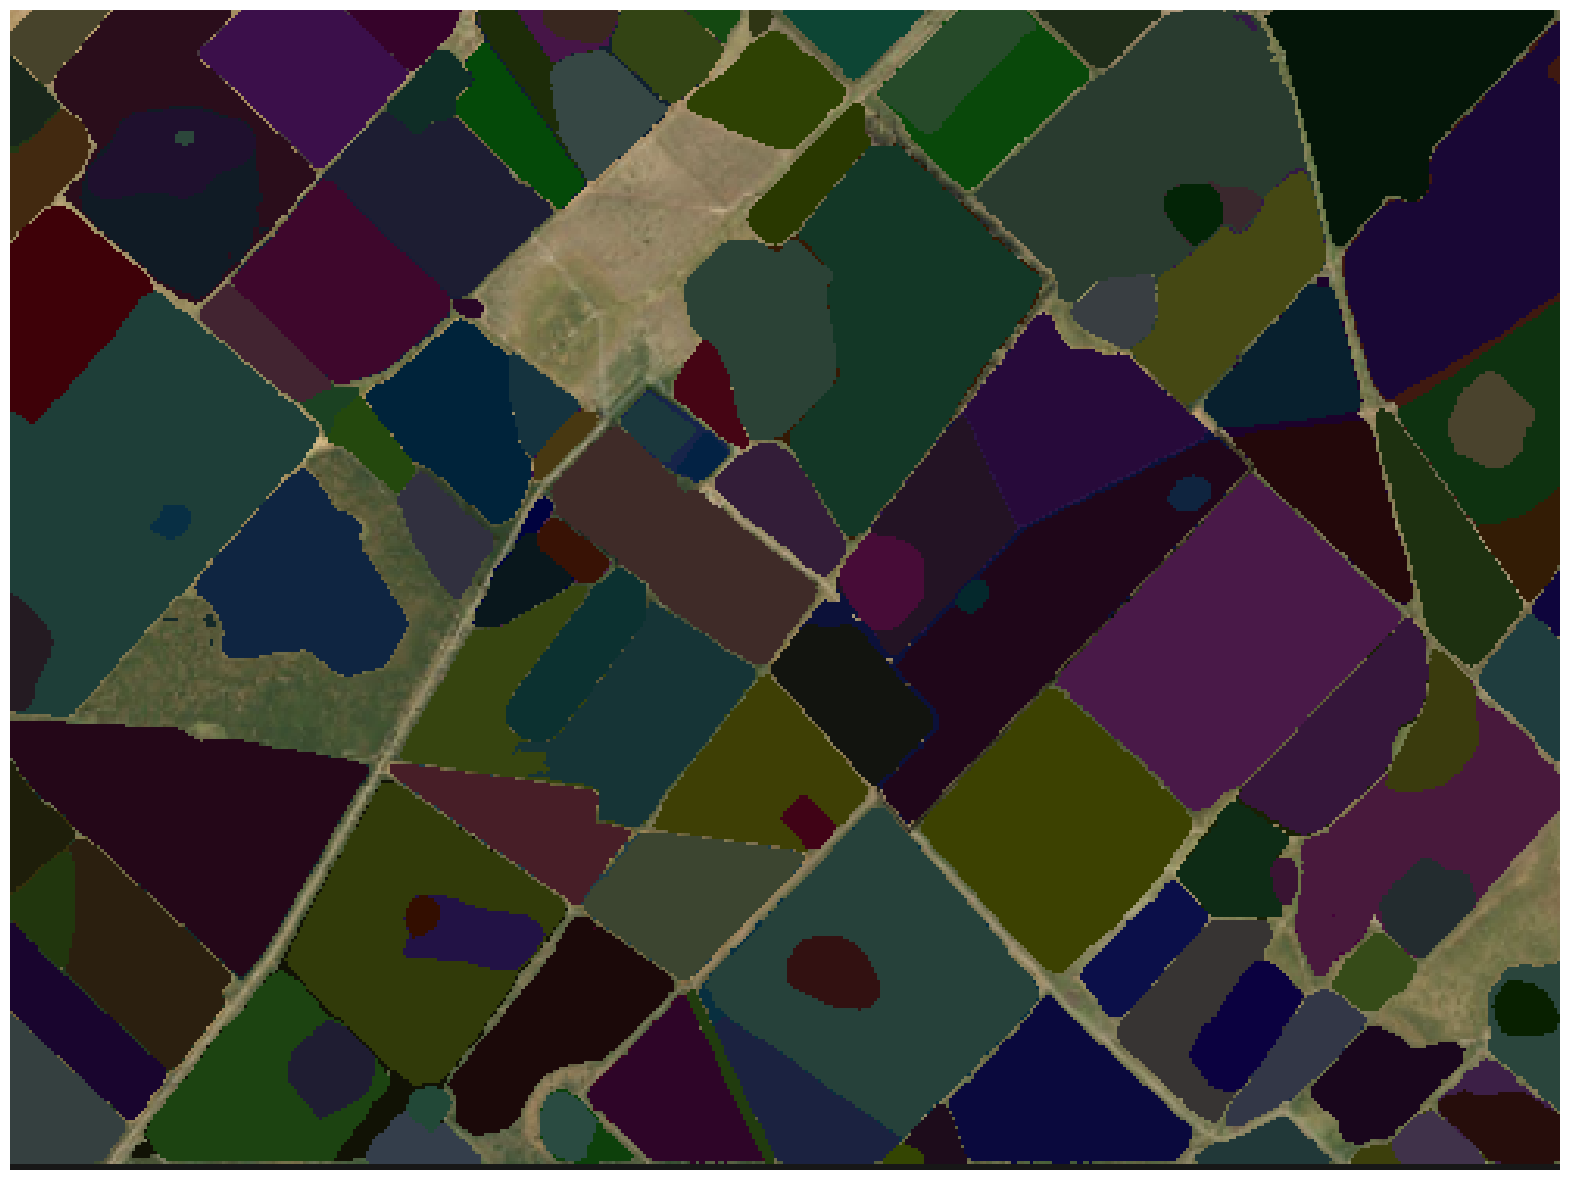

In [57]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()